In [158]:
import pandas as pd

# 读取Excel文件
df = pd.read_excel('data/Served Meal Count.xlsx', usecols=['Date','Breakfast Served','Lunch Served'])

# 将Date列转换为datetime格式
df['Date'] = pd.to_datetime(df['Date'])
# df = df[df['Date'] <= '2024-08-18']
df

,Date,Breakfast Served,Lunch Served
0,2023-08-21,289.0,275.0
1,2023-08-22,332.0,272.0
2,2023-08-23,346.0,288.0
3,2023-08-24,366.0,292.0
4,2023-08-25,367.0,284.0
...,...,...,...
299,2024-10-03,384.0,359.0
300,2024-10-04,381.0,356.0
301,2024-10-05,NaN,NaN
302,2024-10-06,NaN,NaN


In [159]:
# 生成完整的日期范围
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
# 索引设置为Date列
df.set_index('Date', inplace=True)
df

,Breakfast Served,Lunch Served
Date,,
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-10-03,384.0,359.0
2024-10-04,381.0,356.0
2024-10-05,NaN,NaN


In [160]:
# 重索引到完整的日期范围，缺失的日期行填充为NaN
df_full = df.reindex(date_range)
df_full

,Breakfast Served,Lunch Served
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-10-03,384.0,359.0
2024-10-04,381.0,356.0
2024-10-05,NaN,NaN
2024-10-06,NaN,NaN


In [161]:
# 对于缺失值，填充为0
df_full.fillna(0, inplace=True)
df_full

,Breakfast Served,Lunch Served
2023-08-21,289.0,275.0
2023-08-22,332.0,272.0
2023-08-23,346.0,288.0
2023-08-24,366.0,292.0
2023-08-25,367.0,284.0
...,...,...
2024-10-03,384.0,359.0
2024-10-04,381.0,356.0
2024-10-05,0.0,0.0
2024-10-06,0.0,0.0


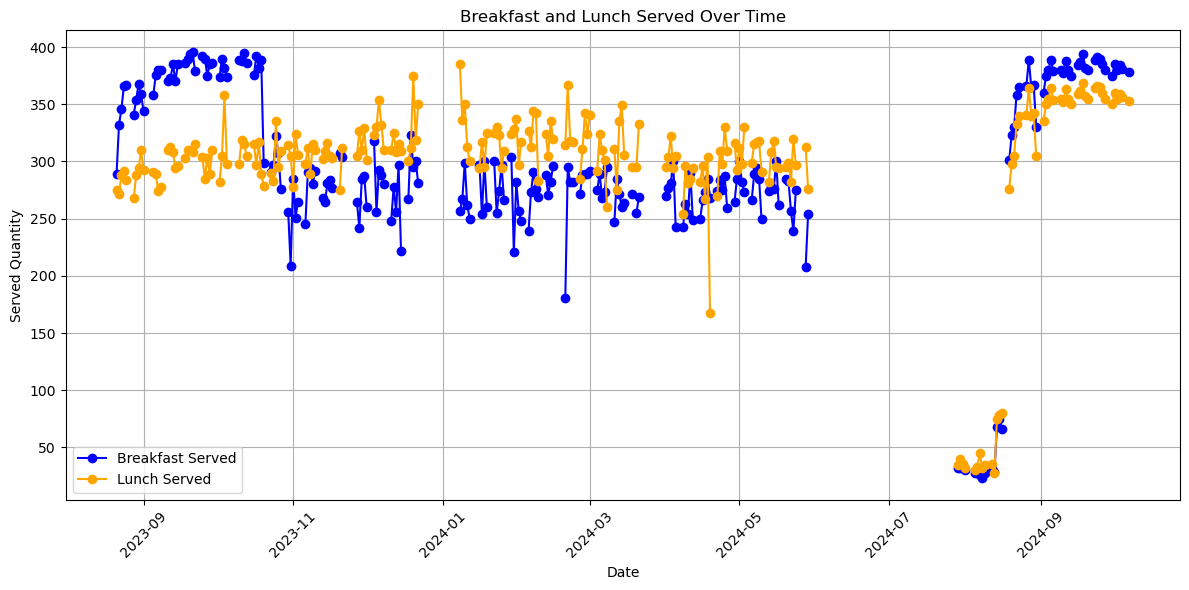

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# 创建副本，替换数值为0的点为NaN
breakfast_plot = df_full['Breakfast Served'].replace(0, np.nan)
lunch_plot = df_full['Lunch Served'].replace(0, np.nan)

# 创建一个图形和坐标轴
plt.figure(figsize=(12, 6))

# 绘制 Breakfast Served 列的折线图
plt.plot(breakfast_plot, label='Breakfast Served', color='blue', marker='o')

# 绘制 Lunch Served 列的折线图
plt.plot(lunch_plot, label='Lunch Served', color='orange', marker='o')

# 添加标题和标签
plt.title('Breakfast and Lunch Served Over Time')
plt.xlabel('Date')
plt.ylabel('Served Quantity')
plt.xticks(rotation=45)  # 旋转 x 轴标签以便更好地显示
plt.legend()  # 显示图例
plt.grid()  # 添加网格

# 显示图形
plt.tight_layout()  # 调整图形以适应布局
plt.show()

In [163]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.pyplot as plt

df_full = df_full

# 生成假期标记（美国）
us_holidays = holidays.US()

# 定义寒暑假日期（示例日期）
winter_break = pd.date_range(start='2023-12-25', end='2024-01-05')
spring_break = pd.date_range(start='2024-03-22', end='2024-03-25')
summer_break = pd.date_range(start='2024-06-03', end='2024-08-20')

# 将寒暑假日期添加到假期标记中
for date in winter_break:
    us_holidays[date] = "Winter Break"
for date in spring_break:
    us_holidays[date] = "Spring Break"
for date in summer_break:
    us_holidays[date] = "Summer Break"

# 添加假期和周末信息
df_full['Is_Holiday'] = df_full.index.map(lambda x: 1 if x in us_holidays else 0)
df_full['Day_of_Week'] = df_full.index.dayofweek
df_full['Is_Weekend'] = df_full['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

# 新增所属月份和当年中的第几天特征
df_full['Month'] = df_full.index.month                   # 所属月份
df_full['Day_of_Year'] = df_full.index.dayofyear          # 当年中的第几天


# 创建滞后特征
for i in range(1, 8):  # 过去7天的订餐量
    df_full[f'Breakfast_Lag_{i}'] = df_full['Breakfast Served'].shift(i)
    df_full[f'Lunch_Lag_{i}'] = df_full['Lunch Served'].shift(i)

# 填充缺失值（假设为0）
df_full.fillna(0, inplace=True)

# 特征选择
features = ['Is_Holiday', 'Is_Weekend', 'Day_of_Week', 'Month', 'Day_of_Year']
features += [f'Breakfast_Lag_{i}' for i in range(1, 8)]
features += [f'Lunch_Lag_{i}' for i in range(1, 8)]

In [164]:
df_full

,Breakfast Served,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Month,Day_of_Year,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_2,...,Breakfast_Lag_3,Lunch_Lag_3,Breakfast_Lag_4,Lunch_Lag_4,Breakfast_Lag_5,Lunch_Lag_5,Breakfast_Lag_6,Lunch_Lag_6,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,289.0,275.0,0,0,0,8,233,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-22,332.0,272.0,0,1,0,8,234,289.0,275.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-23,346.0,288.0,0,2,0,8,235,332.0,272.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-24,366.0,292.0,0,3,0,8,236,346.0,288.0,332.0,...,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-25,367.0,284.0,0,4,0,8,237,366.0,292.0,346.0,...,332.0,272.0,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,384.0,359.0,0,3,0,10,277,380.0,355.0,385.0,...,375.0,350.0,0.0,0.0,0.0,0.0,380.0,355.0,385.0,360.0
2024-10-04,381.0,356.0,0,4,0,10,278,384.0,359.0,380.0,...,385.0,360.0,375.0,350.0,0.0,0.0,0.0,0.0,380.0,355.0
2024-10-05,0.0,0.0,0,5,1,10,279,381.0,356.0,384.0,...,380.0,355.0,385.0,360.0,375.0,350.0,0.0,0.0,0.0,0.0
2024-10-06,0.0,0.0,0,6,1,10,280,0.0,0.0,381.0,...,384.0,359.0,380.0,355.0,385.0,360.0,375.0,350.0,0.0,0.0


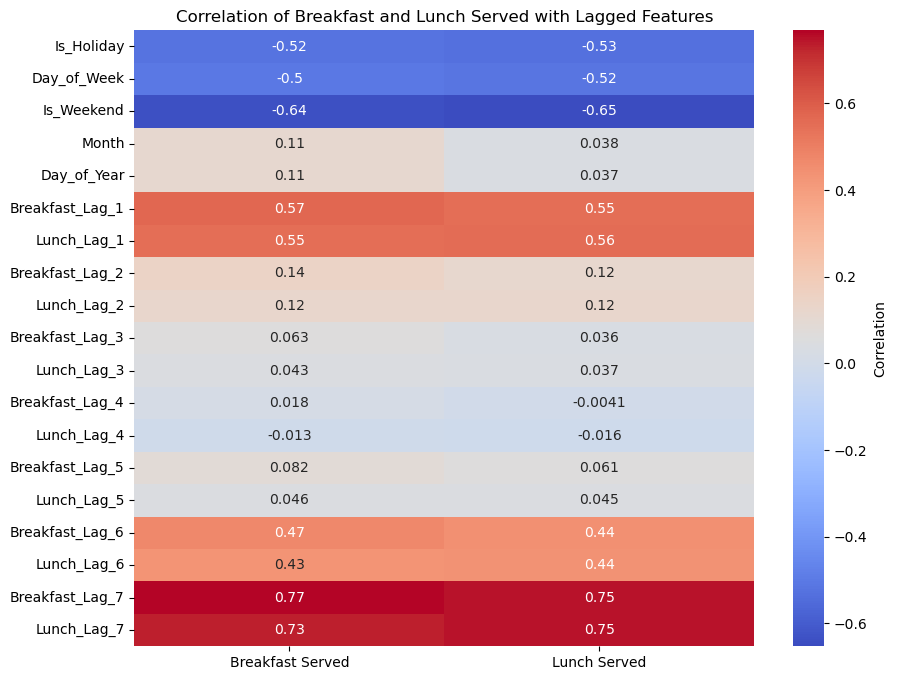

In [165]:
# 选择所有目标和特征列
correlation_features = ['Breakfast Served', 'Lunch Served'] + ['Is_Holiday', 'Is_Weekend', 'Month', 'Day_of_Week', 'Day_of_Year'] + \
                       [f'Breakfast_Lag_{i}' for i in range(1, 8)] + \
                       [f'Lunch_Lag_{i}' for i in range(1, 8)]
correlation_data = df_full

# 计算相关矩阵
correlation_matrix = correlation_data.corr()

# 提取 'Breakfast Served' 和 'Lunch Served' 与滞后特征的相关性
target_corr = correlation_matrix[['Breakfast Served', 'Lunch Served']].drop(['Breakfast Served', 'Lunch Served'])

import seaborn as sns
# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Breakfast and Lunch Served with Lagged Features")
plt.show()

In [166]:
print("筛选出的与目标变量相关性绝对值大于等于0.5的特征列：")
selected_features = target_corr[(target_corr.abs() >= 0.5).any(axis=1)]
print(selected_features)
# 从 data 中筛选符合条件的特征列
selected_feature_names = selected_features.index.tolist()
print(selected_feature_names)
filtered_features = df_full[selected_feature_names]
filtered_features

筛选出的与目标变量相关性绝对值大于等于0.5的特征列：
                 Breakfast Served  Lunch Served
Is_Holiday              -0.521860     -0.533869
Day_of_Week             -0.504454     -0.518853
Is_Weekend              -0.638133     -0.652981
Breakfast_Lag_1          0.570908      0.546838
Lunch_Lag_1              0.548168      0.556823
Breakfast_Lag_7          0.768948      0.749828
Lunch_Lag_7              0.734471      0.749567
['Is_Holiday', 'Day_of_Week', 'Is_Weekend', 'Breakfast_Lag_1', 'Lunch_Lag_1', 'Breakfast_Lag_7', 'Lunch_Lag_7']


,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,0,4,0,366.0,292.0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-03,0,3,0,380.0,355.0,385.0,360.0
2024-10-04,0,4,0,384.0,359.0,380.0,355.0
2024-10-05,0,5,1,381.0,356.0,0.0,0.0
2024-10-06,0,6,1,0.0,0.0,0.0,0.0


In [167]:
# 分割数据集
X = filtered_features
y_breakfast = df_full['Breakfast Served']
y_lunch = df_full['Lunch Served']

In [156]:
X

,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,0,4,0,366.0,292.0,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-03,0,3,0,380.0,355.0,385.0,360.0
2024-10-04,0,4,0,384.0,359.0,380.0,355.0
2024-10-05,0,5,1,381.0,356.0,0.0,0.0
2024-10-06,0,6,1,0.0,0.0,0.0,0.0


In [168]:
y_breakfast

2023-08-21    289.0
2023-08-22    332.0
2023-08-23    346.0
2023-08-24    366.0
2023-08-25    367.0
              ...  
2024-10-03    384.0
2024-10-04    381.0
2024-10-05      0.0
2024-10-06      0.0
2024-10-07    378.0
Freq: D, Name: Breakfast Served, Length: 414, dtype: float64

In [169]:
# Define cutoff date for splitting data
cutoff_date = '2024-08-19'

# Filter training and testing data based on the cutoff date
X_train_breakfast = X_train_lunch = X[X.index < cutoff_date]
y_train_breakfast = y_breakfast[y_breakfast.index < cutoff_date]
y_train_lunch = y_lunch[y_lunch.index < cutoff_date]
# Shuffle the training data
X_train_breakfast_shuffled, y_train_breakfast_shuffled = shuffle(X_train_breakfast, y_train_breakfast, random_state=42)
X_train_lunch_shuffled, y_train_lunch_shuffled = shuffle(X_train_lunch, y_train_lunch, random_state=42)


X_test_breakfast =  X_test_lunch = X[X.index >= cutoff_date]
y_test_breakfast = y_breakfast[y_breakfast.index >= cutoff_date]
y_test_lunch = y_lunch[y_lunch.index >= cutoff_date]

In [170]:
y_train_breakfast.index

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28',
               '2023-08-29', '2023-08-30',
               ...
               '2024-08-09', '2024-08-10', '2024-08-11', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-17', '2024-08-18'],
              dtype='datetime64[ns]', length=364, freq='D')

In [171]:
y_train_breakfast

2023-08-21    289.0
2023-08-22    332.0
2023-08-23    346.0
2023-08-24    366.0
2023-08-25    367.0
              ...  
2024-08-14     68.0
2024-08-15     75.0
2024-08-16     66.0
2024-08-17      0.0
2024-08-18      0.0
Freq: D, Name: Breakfast Served, Length: 364, dtype: float64

In [172]:
y_train_breakfast.tolist()

[289.0,
 332.0,
 346.0,
 366.0,
 367.0,
 0.0,
 0.0,
 341.0,
 354.0,
 368.0,
 359.0,
 344.0,
 0.0,
 0.0,
 0.0,
 358.0,
 376.0,
 380.0,
 380.0,
 0.0,
 0.0,
 370.0,
 373.0,
 385.0,
 370.0,
 385.0,
 0.0,
 0.0,
 386.0,
 390.0,
 394.0,
 396.0,
 379.0,
 0.0,
 0.0,
 392.0,
 390.0,
 375.0,
 385.0,
 386.0,
 0.0,
 0.0,
 374.0,
 390.0,
 382.0,
 374.0,
 0.0,
 0.0,
 0.0,
 0.0,
 389.0,
 388.0,
 395.0,
 386.0,
 0.0,
 0.0,
 376.0,
 392.0,
 382.0,
 389.0,
 299.0,
 0.0,
 0.0,
 291.0,
 297.0,
 322.0,
 307.0,
 276.0,
 0.0,
 0.0,
 256.0,
 209.0,
 285.0,
 251.0,
 265.0,
 0.0,
 0.0,
 245.0,
 291.0,
 294.0,
 280.0,
 292.0,
 0.0,
 0.0,
 268.0,
 265.0,
 281.0,
 284.0,
 277.0,
 0.0,
 0.0,
 307.0,
 304.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 265.0,
 242.0,
 285.0,
 287.0,
 260.0,
 0.0,
 0.0,
 318.0,
 256.0,
 293.0,
 288.0,
 280.0,
 0.0,
 0.0,
 248.0,
 278.0,
 256.0,
 297.0,
 222.0,
 0.0,
 0.0,
 267.0,
 323.0,
 295.0,
 300.0,
 281.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

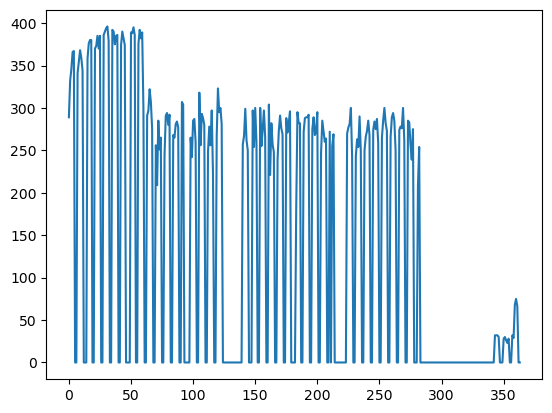

In [173]:
plt.plot(y_train_breakfast.tolist())

In [143]:

# 划分数据集并保留原始索引
# X_train_breakfast, X_test_breakfast, y_train_breakfast, y_test_breakfast, train_index_breakfast, test_index_breakfast = train_test_split(
#     X, y_breakfast, X.index, test_size=0.2, random_state=42
# )
# X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch, train_index_lunch, test_index_lunch = train_test_split(
#     X, y_lunch, X.index, test_size=0.2, random_state=42
# )

In [174]:
# 使用随机森林回归模型
breakfast_model = RandomForestRegressor(n_estimators=256, random_state=42)
lunch_model = RandomForestRegressor(n_estimators=256, random_state=42)

# 模型训练
breakfast_model.fit(X_train_breakfast_shuffled, y_train_breakfast_shuffled)
lunch_model.fit(X_train_lunch_shuffled, y_train_lunch_shuffled)

# 模型推理
pred_train_breakfast = breakfast_model.predict(X_train_breakfast)
pred_train_lunch = lunch_model.predict(X_train_lunch)

pred_test_breakfast = breakfast_model.predict(X_test_breakfast)
pred_test_lunch = lunch_model.predict(X_test_lunch)

pred_breakfast = breakfast_model.predict(X)
pred_lunch = lunch_model.predict(X)

In [175]:
pred_train_breakfast

array([3.05017577e+02, 3.04948242e+02, 3.34855469e+02, 3.48710938e+02,
       3.33105469e+02, 2.86718750e+00, 0.00000000e+00, 3.06265137e+02,
       3.14210938e+02, 3.62992188e+02, 3.63917969e+02, 3.29562500e+02,
       2.86328125e+00, 0.00000000e+00, 5.75000000e+00, 3.58371094e+02,
       3.69929688e+02, 3.75476562e+02, 3.76039062e+02, 0.00000000e+00,
       0.00000000e+00, 3.05017577e+02, 3.71937500e+02, 3.63222656e+02,
       3.70500000e+02, 3.47882812e+02, 0.00000000e+00, 0.00000000e+00,
       3.68066406e+02, 3.87769531e+02, 3.90355469e+02, 3.90316406e+02,
       3.42519531e+02, 0.00000000e+00, 0.00000000e+00, 3.81148438e+02,
       3.86335938e+02, 3.73449219e+02, 3.57464844e+02, 3.24902344e+02,
       0.00000000e+00, 0.00000000e+00, 3.67226562e+02, 3.52531250e+02,
       3.83945312e+02, 3.75671875e+02, 1.32898438e+02, 0.00000000e+00,
       0.00000000e+00, 7.25781250e+00, 3.77386719e+02, 3.82730469e+02,
       3.91152344e+02, 3.47871094e+02, 0.00000000e+00, 0.00000000e+00,
      

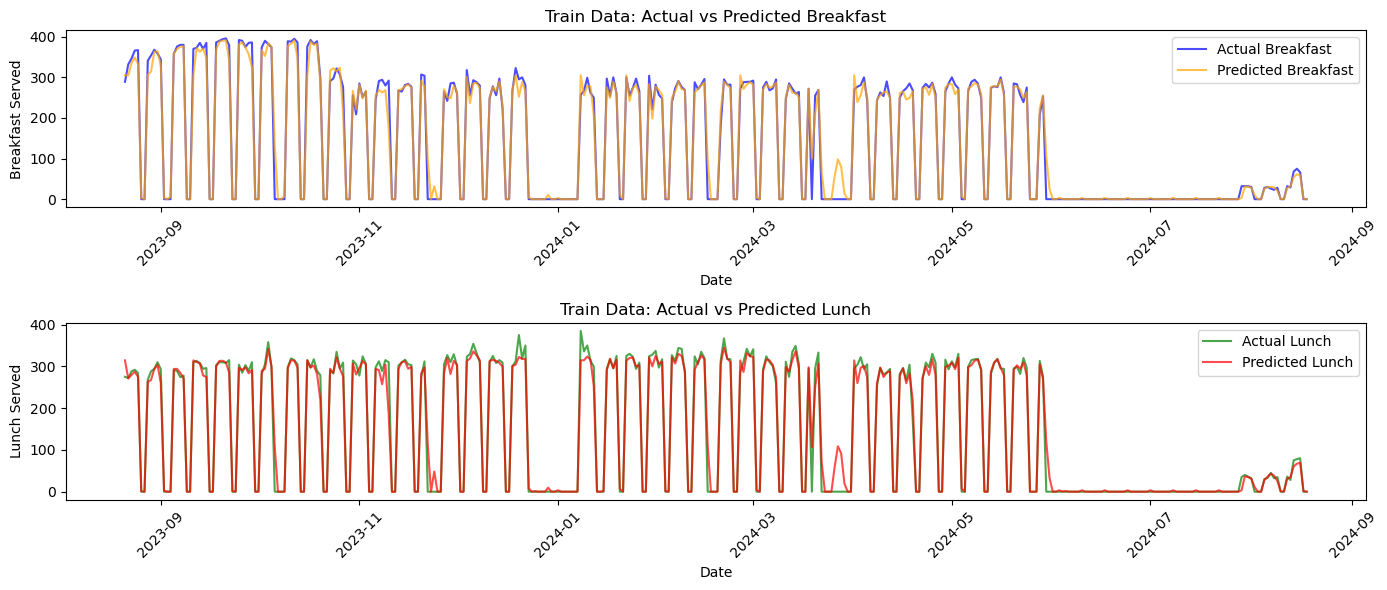

In [178]:
# 绘制未划分数据集的真实标签与预测标签对比
plt.figure(figsize=(14, 6))

# 早餐：完整数据集的真实值与预测值对比
plt.subplot(2, 1, 1)
plt.plot(y_train_breakfast.index, y_train_breakfast, label='Actual Breakfast', color='blue', alpha=0.7)
plt.plot(y_train_breakfast.index, pred_train_breakfast, label='Predicted Breakfast', color='orange', alpha=0.7)
plt.title('Train Data: Actual vs Predicted Breakfast')
plt.xlabel('Date')
plt.ylabel('Breakfast Served')
plt.legend()
plt.xticks(rotation=45)

# 午餐：完整数据集的真实值与预测值对比
plt.subplot(2, 1, 2)
plt.plot(y_train_lunch.index, y_train_lunch, label='Actual Lunch', color='green', alpha=0.7)
plt.plot(y_train_lunch.index, pred_train_lunch, label='Predicted Lunch', color='red', alpha=0.7)
plt.title('Train Data: Actual vs Predicted Lunch')
plt.xlabel('Date')
plt.ylabel('Lunch Served')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

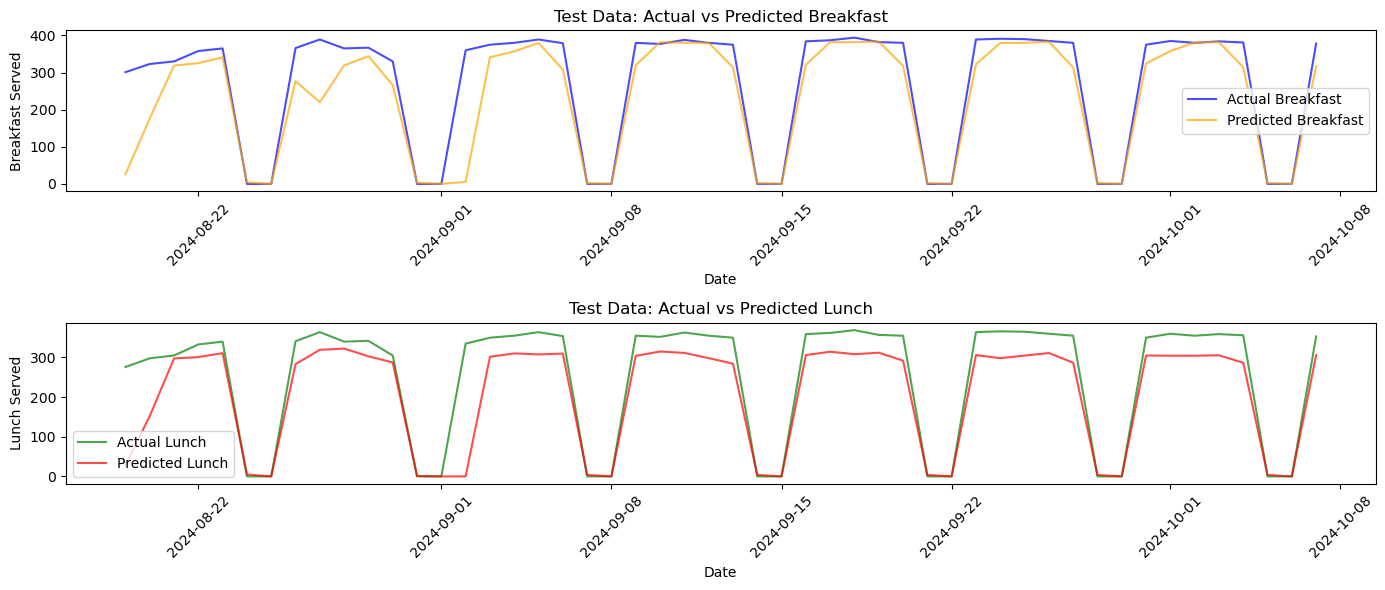

In [179]:
# 绘制未划分数据集的真实标签与预测标签对比
plt.figure(figsize=(14, 6))

# 早餐：完整数据集的真实值与预测值对比
plt.subplot(2, 1, 1)
plt.plot(y_test_breakfast.index, y_test_breakfast, label='Actual Breakfast', color='blue', alpha=0.7)
plt.plot(y_test_breakfast.index, pred_test_breakfast, label='Predicted Breakfast', color='orange', alpha=0.7)
plt.title('Test Data: Actual vs Predicted Breakfast')
plt.xlabel('Date')
plt.ylabel('Breakfast Served')
plt.legend()
plt.xticks(rotation=45)

# 午餐：完整数据集的真实值与预测值对比
plt.subplot(2, 1, 2)
plt.plot(y_test_lunch.index, y_test_lunch, label='Actual Lunch', color='green', alpha=0.7)
plt.plot(y_test_lunch.index, pred_test_lunch, label='Predicted Lunch', color='red', alpha=0.7)
plt.title('Test Data: Actual vs Predicted Lunch')
plt.xlabel('Date')
plt.ylabel('Lunch Served')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Breakfast MSE: 6212.185232526942
Lunch MSE: 5572.664991865605
Breakfast MAE: 40.675680336373695
Lunch MAE: 46.89815287035013
Breakfast R² Score: 0.7807138439494222
Lunch R² Score: 0.7743583199001475


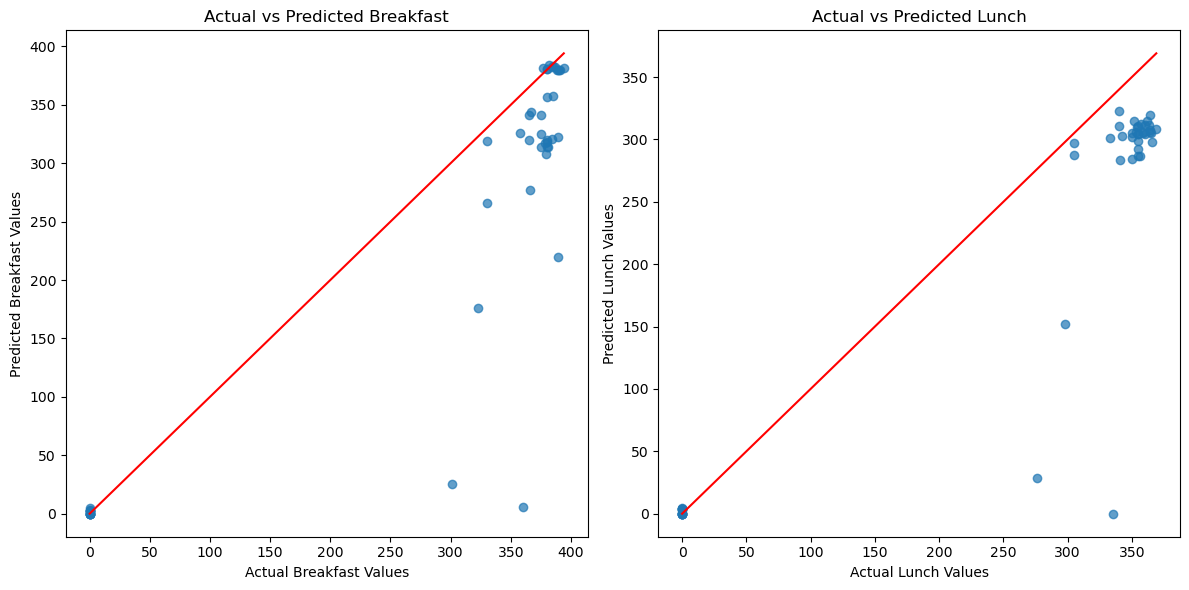

In [180]:

# 模型性能评估
breakfast_mse = mean_squared_error(y_test_breakfast, pred_test_breakfast)
lunch_mse = mean_squared_error(y_test_lunch, pred_test_lunch)
breakfast_mae = mean_absolute_error(y_test_breakfast, pred_test_breakfast)
lunch_mae = mean_absolute_error(y_test_lunch, pred_test_lunch)
breakfast_r2 = r2_score(y_test_breakfast, pred_test_breakfast)
lunch_r2 = r2_score(y_test_lunch, pred_test_lunch)

print(f'Breakfast MSE: {breakfast_mse}')
print(f'Lunch MSE: {lunch_mse}')
print(f'Breakfast MAE: {breakfast_mae}')
print(f'Lunch MAE: {lunch_mae}')
print(f'Breakfast R² Score: {breakfast_r2}')
print(f'Lunch R² Score: {lunch_r2}')

# 可视化评估
plt.figure(figsize=(12, 6))

# 散点图
plt.subplot(1, 2, 1)
plt.scatter(y_test_breakfast, pred_test_breakfast, alpha=0.7)
plt.xlabel('Actual Breakfast Values')
plt.ylabel('Predicted Breakfast Values')
plt.title('Actual vs Predicted Breakfast')
plt.plot([y_test_breakfast.min(), y_test_breakfast.max()],
         [y_test_breakfast.min(), y_test_breakfast.max()], color='red')  # 理想预测线

plt.subplot(1, 2, 2)
plt.scatter(y_test_lunch, pred_test_lunch, alpha=0.7)
plt.xlabel('Actual Lunch Values')
plt.ylabel('Predicted Lunch Values')
plt.title('Actual vs Predicted Lunch')
plt.plot([y_test_lunch.min(), y_test_lunch.max()],
         [y_test_lunch.min(), y_test_lunch.max()], color='red')  # 理想预测线

plt.tight_layout()
plt.show()

## 后面需要修改

In [68]:
# 手动指定初始的七天滞后数据
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]
previous_days = len(initial_lags_breakfast)

# 设置预测的天数
prediction_days = 7
future_dates = pd.date_range(start=df_full.index[-1] + pd.Timedelta(days=previous_days), periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

future_data

,Is_Holiday,Day_of_Week,Is_Weekend,Month,Day_of_Year
2024-08-25,0,6,1,8,238
2024-08-26,0,0,0,8,239
2024-08-27,0,1,0,8,240
2024-08-28,0,2,0,8,241
2024-08-29,0,3,0,8,242
2024-08-30,0,4,0,8,243
2024-08-31,0,5,1,8,244


In [69]:
# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

# 基于相关性筛选出的特征（根据之前的特征筛选步骤获取）


for date in future_dates:
    # 创建滞后特征，使用当前的7天滞后数据
    for i in range(7):
        future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i+1)]
        future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i+1)]

    # 筛选出相关性特征，构建模型输入数据
    X_future = future_data.loc[date, selected_feature_names].values.reshape(1, -1)
    print(X_future)
    # 使用模型进行预测
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)
    initial_lags_breakfast.pop(0)
    initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


[[  0.   1. 299. 320. 254. 270.]]
[[  0.           0.         193.640625   211.49609375 300.
  315.        ]]
[[  0.           0.         265.54296875 311.83984375 321.
  340.        ]]
[[  0.          0.        275.7421875 287.640625  298.        310.       ]]
[[  0.           0.         275.71484375 313.3046875  341.
  350.        ]]
[[  0.           0.         293.484375   314.39453125 300.
  305.        ]]
[[  0.        1.      284.34375 316.96875 299.      320.     ]]


D:\app-ness\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\app-ness\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\app-ness\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\app-ness\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\app-ness\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\app-ness\anaconda3\envs\dev\lib\

,Predicted_Breakfast,Predicted_Lunch
2024-08-25,193.640625,211.496094
2024-08-26,265.542969,311.839844
2024-08-27,275.742188,287.640625
2024-08-28,275.714844,313.304688
2024-08-29,293.484375,314.394531
2024-08-30,284.343750,316.968750
2024-08-31,283.726562,306.527344


In [150]:
# 手动指定初始的七天滞后数据（可以少于7天）
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]

# 设置预测的天数（例如7天）
prediction_days = 7

# 确定起始日期，去掉手动指定的那几天（假设为len(initial_lags_breakfast)天）
start_date = df_full.index[-1] + pd.Timedelta(days=1) - pd.Timedelta(days=len(initial_lags_breakfast))

# 生成未来预测日期
future_dates = pd.date_range(start=start_date, periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

for date in future_dates:
    # 创建滞后特征，确保使用的滞后数据长度为7
    for i in range(7):
        if len(initial_lags_breakfast) >= (i + 1):
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i + 1)]
        else:
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

        if len(initial_lags_lunch) >= (i + 1):
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i + 1)]
        else:
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

    # 使用模型进行预测
    X_future = future_data.loc[date, features].values.reshape(1, -1)
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)

    # 确保长度保持在7个元素
    if len(initial_lags_breakfast) > 7:
        initial_lags_breakfast.pop(0)
    if len(initial_lags_lunch) > 7:
        initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles

,Predicted_Breakfast,Predicted_Lunch
2024-08-14,174.226562,182.031250
2024-08-15,81.175781,79.921875
2024-08-16,47.906250,48.437500
2024-08-17,4.753906,6.054688
2024-08-18,9.039062,6.054688
2024-08-19,0.000000,0.000000
2024-08-20,0.000000,0.000000


In [151]:
# 手动指定初始的七天滞后数据（可以少于7天）
initial_lags_breakfast = [254, 300, 321, 298, 341, 300, 299]
initial_lags_lunch = [270, 315, 340, 310, 350, 305, 320]

# 获取数据的最后一天
last_date = df_full.index[-1]
# 计算预测的起始日期
start_prediction_date = last_date + pd.Timedelta(days=len(initial_lags_breakfast))

# 设置预测的天数（例如7天）
prediction_days = 7
future_dates = pd.date_range(start=start_prediction_date, periods=prediction_days)
future_data = pd.DataFrame(index=future_dates)

# 初始化特征
future_data['Is_Holiday'] = future_data.index.map(lambda x: 1 if x in us_holidays else 0)
future_data['Day_of_Week'] = future_data.index.dayofweek
future_data['Is_Weekend'] = future_data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['Month'] = future_data.index.month
future_data['Day_of_Year'] = future_data.index.dayofyear

# 逐步预测未来几天的数据，并更新滞后特征
breakfast_predictions = []
lunch_predictions = []

for date in future_dates:
    # 创建滞后特征，确保使用的滞后数据长度为7
    for i in range(7):
        if len(initial_lags_breakfast) >= (i + 1):
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = initial_lags_breakfast[-(i + 1)]
        else:
            future_data.loc[date, f'Breakfast_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

        if len(initial_lags_lunch) >= (i + 1):
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = initial_lags_lunch[-(i + 1)]
        else:
            future_data.loc[date, f'Lunch_Lag_{i+1}'] = 0  # 如果没有数据，填充为0

    # 使用模型进行预测
    X_future = future_data.loc[date, features].values.reshape(1, -1)
    breakfast_pred = breakfast_model.predict(X_future)[0]
    lunch_pred = lunch_model.predict(X_future)[0]

    # 将预测值存储
    breakfast_predictions.append(breakfast_pred)
    lunch_predictions.append(lunch_pred)

    # 更新滞后特征（把当天的预测值加入滞后列表末尾，并移除最早的值）
    initial_lags_breakfast.append(breakfast_pred)
    initial_lags_lunch.append(lunch_pred)

    # 确保长度保持在7个元素
    if len(initial_lags_breakfast) > 7:
        initial_lags_breakfast.pop(0)
    if len(initial_lags_lunch) > 7:
        initial_lags_lunch.pop(0)

# 将预测结果添加到 future_data 中
future_data['Predicted_Breakfast'] = breakfast_predictions
future_data['Predicted_Lunch'] = lunch_predictions

# 查看未来一周的预测结果
future_data[['Predicted_Breakfast', 'Predicted_Lunch']]


D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles\anaconda3\envs\dev\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\ProgramFiles

,Predicted_Breakfast,Predicted_Lunch
2024-08-27,227.324219,266.199219
2024-08-28,241.667969,295.250000
2024-08-29,170.617188,191.378906
2024-08-30,292.304688,282.847656
2024-08-31,323.152344,281.847656
2024-09-01,247.167969,300.046875
2024-09-02,67.296875,70.234375
